# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** XXXX

**Author 1 (sciper):** XXXX (XXXXXX)  
**Author 2 (sciper):** XXXX (XXXXXX)   
**Author 3 (sciper):** XXXX (XXXXXX)  

**Release date:** 24.03.2023  
**Due date:** 07.04.2023 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library. In the `lab-02-data` folder, you will find 28x28 grey-scale pictures of handwritten "0", "1", "2" and "3".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [56]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

### 0.1.Data visualization

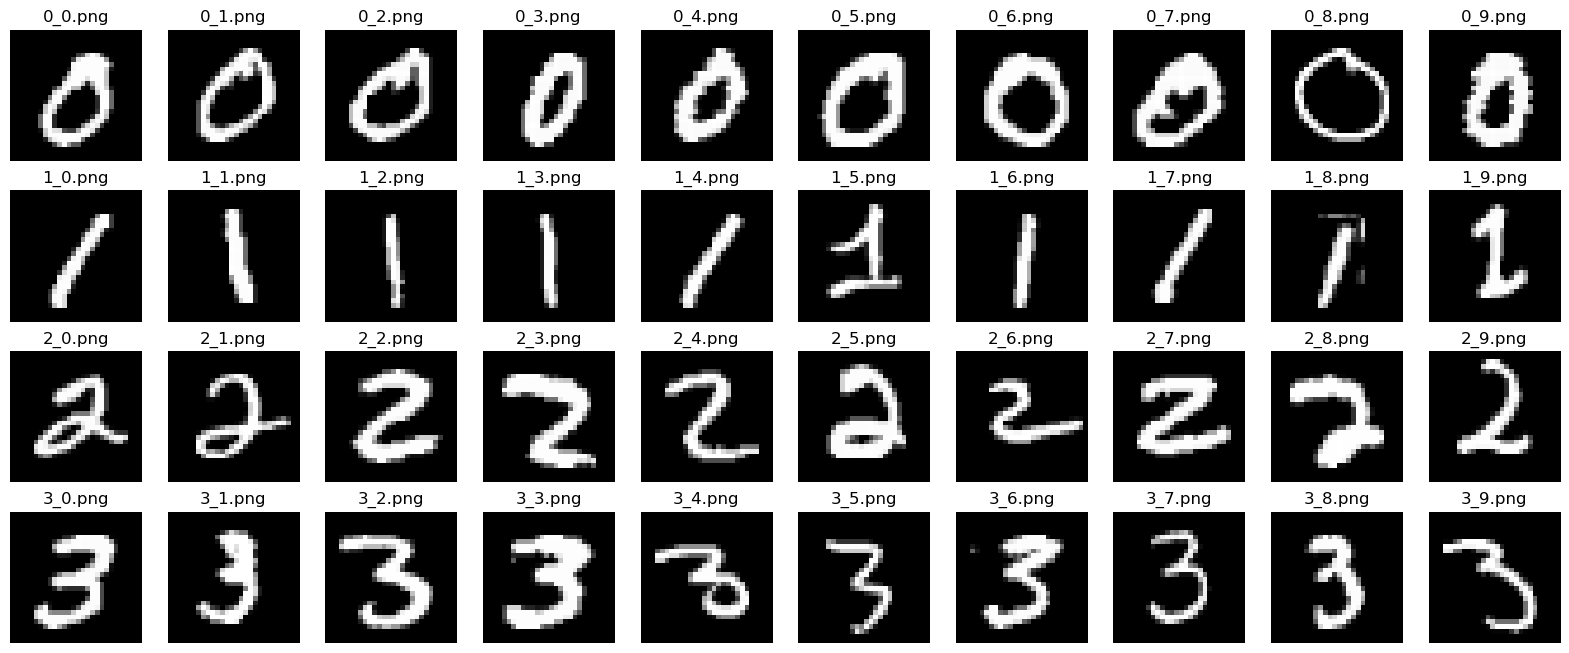

In [57]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
# Load digits data

# Zero images arrays
zeros_im, zeros_names = load(data_part1, digit='0')
# Ones images arrays
ones_im, ones_names = load(data_part1, digit='1')
# Twos images arrays
twos_im, twos_names = load(data_part2, digit='2')
# Threes images arrays
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 8))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

---
## Part 1 - contour based descriptors (18 pts)

In this part you will use images of "0"s and "1"s.

**Objectives overview**: Fourier Descriptors


**1)** *Preprocess*: Select ONLY "0" and "1" images and apply suitable preprocessing. Show a plot with the preprocessed data and give arguments on the chosen techniques. (**2 pts**)


**2)** *Get descriptors*: Find the contours and get the Fourier descriptors in complex definition. *Note*: The contours arrays should contain a finite number (N-> self-chosen) of equi-distant points for each image (hint: interpolation). In the case of the "0" contours, just keep the outermost contour. Discuss the necessity of this format. (**4 pts**)
    
    
**3)** *Study effect of descriptors* : Show the contour-reconstruction of the digits using different amount of descriptors (both for ONE "0" image and ONE "1" image)
- Make 5 plots, reconstructing the digits' countours using different amounts of descriptors. (e.g. reconstruct the contour using the only the 1st fourier descriptor, reconstruct using the first two fourier descriptors,  using the first three ...)  
- **Hint**: check scipy fft, ifft, and fftfreq functions (see [link](https://docs.scipy.org/doc/scipy/tutorial/fft.html)) and pay attention on the ordering, observing which coefficients correspond to positive/negative frequencies of components and how you choose your low frequency subsets . 
- **Extra hint** To reconstruct the contour, copy the original vector of the fourier descriptors, keep the positive an negative frequencies you will use, and set to 0 the rest. (e.g. If you want to reconstruc the image with the first _three fourier descriptors_, keep the first _three positive frecuencies_ and their respective _three negative frequencies_ (see positive and negative bin freque
    frequencies [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ). 
- Discuss about your findings. (**4 pts**)
    
        
**4)** *Clustering*: For each image containing a "0" or a "1", using the fourier descriptors, extract a 2-dimensional feature vector (using the THE POSITIVE bin frequencies from fftfreq, see [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ) and plot all of them on a 2D graph. Did you obtain a plot where the vectors of the "0"'s nicely cluster in one part of the plane and those of the "1"'s in the other? If yes, explain why. (**2 pts**)
    
    
**5)** *Show translation, rotation and scale invariance*
- Firstly, discuss which descriptors, or which part of the descriptors are affected by each transformation. For each transformation define (write in words) an operation which will be applied to the descriptor arrays, such that they will be invariant to (not affected by) the specific transformation anymore. After finding the necessary operations, define a function that will make the Fourier descriptors invariant to all the transformations, altogether.(**3 pts**) 
- Secondly, show that if you are using descriptors invariant to transformations, you still obtain 2 nicely defined clusters for the 2 categories of numbers, under transformations applied. (You need to define custom functions for each transformation, apply them on images, and compare the obtained invariant descriptors). Discuss your findings. (**3 pts**)

### 1. Fourier Descriptors

### 1.1. Preprocess and visualization (2 pts)

The preprocessing consists in a binarization and some morphology to make the contours sharper.

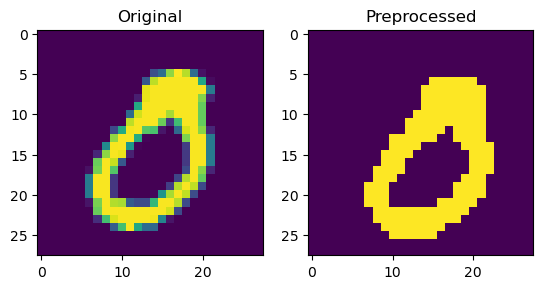

In [58]:
import cv2
import numpy as np
from skimage.morphology import disk, closing, opening

kernel_dilate = np.ones((2,2), np.uint8)
kernel_erode = np.ones((2,2), np.uint8)
zeros_im_bin = []
ones_im_bin = []
for i in range(len(zeros_im)):
    _, im0 = cv2.threshold(zeros_im[i], 50, 255, cv2.THRESH_BINARY)
    _, im1 = cv2.threshold(ones_im[i], 50, 255, cv2.THRESH_BINARY)
    
    im0 = cv2.erode(im0,kernel_erode)
    im1 = cv2.erode(im1,kernel_erode)
    im0 = cv2.dilate(im0,kernel_dilate)
    im1 = cv2.dilate(im1,kernel_dilate)
    
    zeros_im_bin.append(im0)
    ones_im_bin.append(im1)

fig, axs = plt.subplots(1,2)
axs[0].imshow(zeros_im[0])
axs[1].imshow(zeros_im_bin[0])
axs[0].set_title('Original')
axs[1].set_title('Preprocessed')
plt.show()

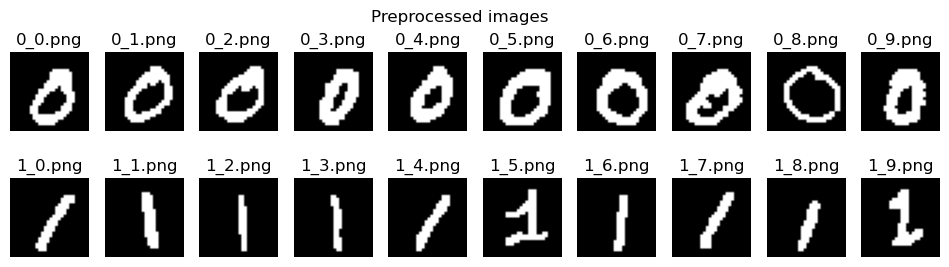

In [59]:
## TODO: Fill the lists below with your preprocessed images of "0"s and "1"s  
zeros = zeros_im_bin
ones = ones_im_bin

# Plot images
fig, axes = plt.subplots(2, len(zeros), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle("Preprocessed images")
plt.show()

#### Discussion
Most of the images are fine now and have sharp and homogeneous edges. Some of them however could be sharper. A smoothing could be an idea to have less sharp

### 1.2. Get descriptors (4 pts)

In [60]:
# Function that takes as input an image and returns a set of descriptors. 
# You may use other custom helper functions to break the code into useful chuncks.
from scipy.fft import fft, ifft
# TODO

def get_contours(img):
    # We first get the contours :
    num_interp = 100
    cont,_ = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    cont = cont[0]
    x = cont[:,0,0]
    y = cont[:,0,1]
    t = np.arange(len(x))
    t_int = np.linspace(0,len(x)-1,num_interp)
    x_int = np.interp(t_int,t,x)
    x_int = x_int.astype(np.int32)
    y_int = np.interp(t_int,t,y)
    y_int = y_int.astype(np.int32)
    contour_complex = []
    descriptors = []
    for i in range(len(x_int)):
        contour_complex.append(complex(x_int[i],y_int[i]))
    return contour_complex, x, y

def get_descriptors(img):
    contour, x, y = get_contours(img)
    descriptors = fft(contour) 
    return descriptors, x, y

# Check first 10 descriptors of a test image (just to check that your pipeline works well)
print(get_descriptors(zeros_im[0])[:10])

(array([ 1.38700000e+03+1.43400000e+03j,  1.75467322e+02-6.92949637e+01j,
        1.47444437e+01-1.20184407e+01j,  1.23462451e+01+2.35372264e+00j,
       -1.64651453e+01+7.28998772e+00j, -1.93386331e+01-8.18561581e+00j,
       -2.54087152e+00-5.76466176e+00j, -6.95888585e-01-5.71680096e+00j,
        5.01737854e-01+4.03508699e+00j,  6.40652873e-01+5.57642175e+00j,
       -2.46169693e-01-2.33067270e+00j,  5.95652760e-01-1.14069649e+00j,
       -7.61876324e-01-2.07269603e+00j, -1.57866933e+00-1.39661158e+00j,
       -1.51363843e+00+8.34228834e-01j,  4.78023007e-01+7.82050504e-01j,
       -2.40980093e+00+5.13463733e+00j,  2.85906208e+00+1.34960712e+00j,
       -1.73129880e+00-4.88084237e+00j,  2.45901648e+00-2.44093463e+00j,
       -1.45105652e+00-1.84785876e+00j, -3.29016452e+00+2.52236835e+00j,
       -7.02824772e-02+3.63708362e+00j, -5.20079181e-02-3.50460942e+00j,
       -3.71819691e+00+2.50653209e+00j,  1.16573418e-15+1.00000000e+00j,
       -2.79624626e+00+7.15231474e-01j,  1.3302741

#### Discussion

TODO

### 1.3. Study effect of descriptors (6 pts)

In [61]:
# Define increasing set sizes of the descriptors. You can also change these numbers.
descr_set_sizes = [1, 2, 5, 10, 20]

# Define images for which you will show the recovery. You can also change the indexes.
zero = zeros_im[0]
one = ones_im[0]

In [62]:
# TODO

def get_reconstructed(descriptors):
    reconstructed = []
    for descr in descr_set_sizes:
        sub_descr = np.zeros(len(descriptors))
        sub_descr[:descr] = 1
        sub_descr[len(sub_descr)-descr:len(sub_descr)] = 1
        sub_descr = np.multiply(sub_descr,descriptors)
        reconstructed.append(ifft(sub_descr))
    return reconstructed

descriptors_zero, x_zero, y_zero = get_descriptors(zero)
descriptors_one, x_one, y_one = get_descriptors(one)
reconstructed_0 = get_reconstructed(descriptors_zero)
reconstructed_1 = get_reconstructed(descriptors_one)

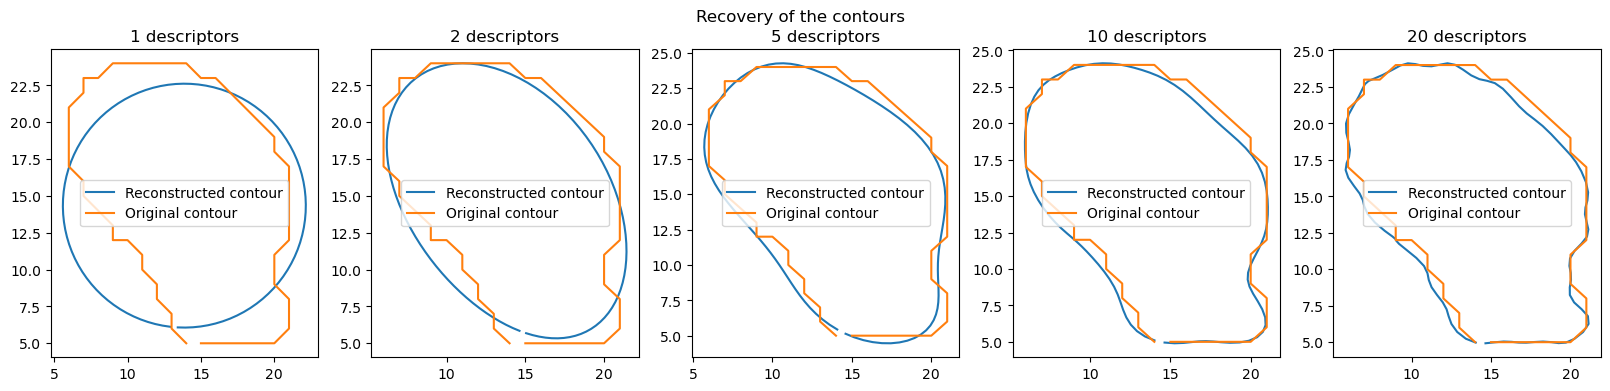

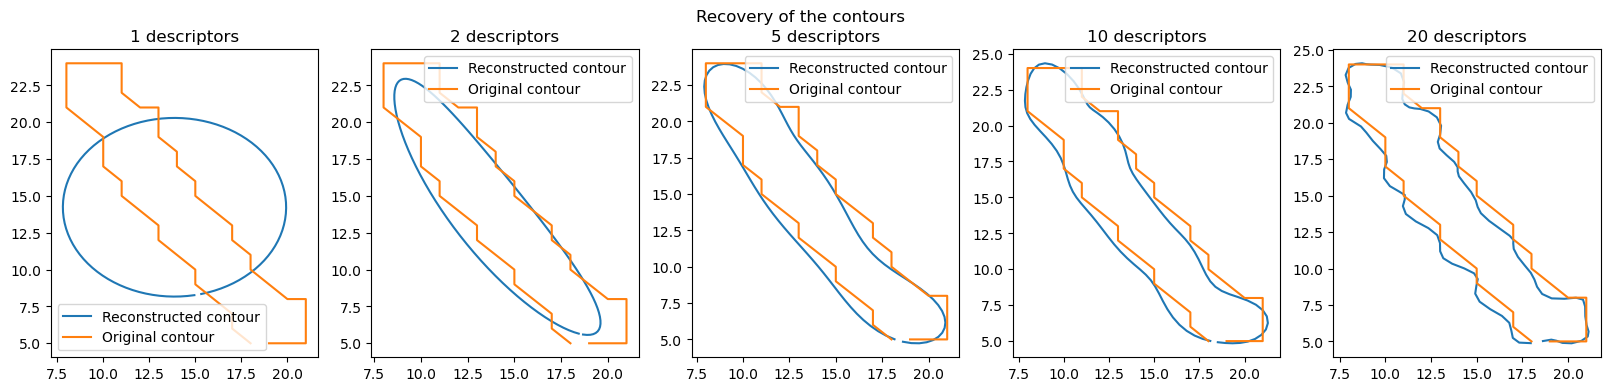

In [63]:
# On each of the 5 plots you will show the recovery for a "0" and a "1" (used the same axis for both a "0" and a "1").

# Plot recovery for a zero image

def plot_reconstructed(reconstructed, x_original, y_original):
    for i in range(0,  5):
        x = np.zeros(len(reconstructed[i]))
        y = np.zeros(len(reconstructed[i]))
        for j in range(len(reconstructed[i])):
            x[j] = reconstructed[i][j].real
            y[j] = reconstructed[i][j].imag
        axes[i].plot(x,y)
        axes[i].set_title(str(descr_set_sizes[i]) + " descriptors")
        axes[i].plot(x_original, y_original)
        axes[i].legend(["Reconstructed contour", "Original contour"])
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
plot_reconstructed(reconstructed_0, x_zero, y_zero)
fig.suptitle("Recovery of the contours")
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
plot_reconstructed(reconstructed_1, x_one, y_one)
fig.suptitle("Recovery of the contours")
plt.show()

#### Discussion

TODO

### 1.4 Clustering (2 pts)

In [64]:
def extract_feature_vector(descriptors, nb=2):
    # Select only the positive frequency components
    n = descriptors.shape[0]
    pos_coeffs = descriptors[:n//2]
    principal=pos_coeffs[:nb]
    principal=np.real(principal)
    return principal

10
[1496.0, 1536.0, 1502.0, 1462.0, 1484.0, 1462.0, 1511.0, 1487.0, 1402.0, 1462.0]


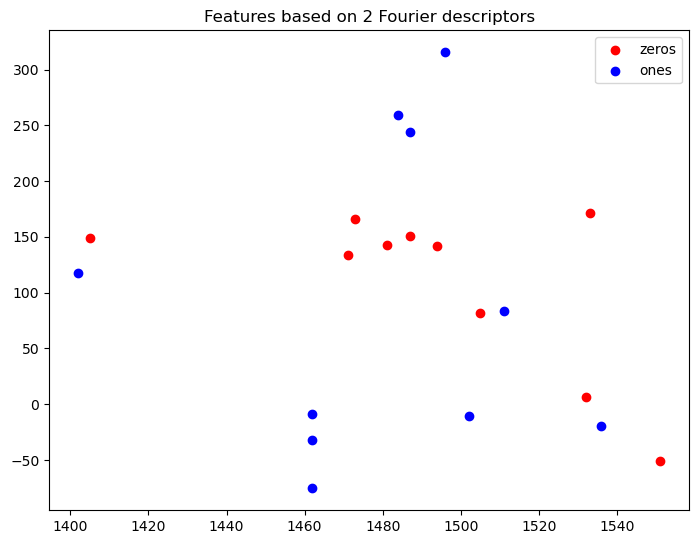

In [65]:
# TODO: You should fill the lists below, with your features

# features for all "0"s
zeros_f1, zeros_f2 = [], []
ones_f1, ones_f2 = [], []
print(len(zeros))
for z in zeros:
    descriptors_zero, x_zero, y_zero = get_descriptors(z)
    zero_f1, zero_f2 = extract_feature_vector(descriptors_zero)
    zeros_f1.append(zero_f1)
    zeros_f2.append(zero_f2)
# Fist feature for all "1"s
for o in ones:
    descriptors_one, x_ones, y_ones = get_descriptors(o)
    one_f1, one_f2 = extract_feature_vector(descriptors_one)
    ones_f1.append(one_f1)
    ones_f2.append(one_f2)

print(ones_f1)
# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(zeros_f1, zeros_f2, color='r', label='zeros')
ax.scatter(ones_f1, ones_f2, color='b', label='ones')
ax.legend(loc='best')
plt.title("Features based on 2 Fourier descriptors")
plt.show()

#### Discussion


TODO

### 1.5 Transformation invariance (6 pts)

#### Preliminary discussion
Translation, rotation, and scale are common image transformations that can affect the Fourier descriptors of a contour.

Translation is the process of relocating an object without altering its shape or orientation. The DC component of the Fourier descriptors, which corresponds to the contour's centroid, is affected by translation. To ensure that the descriptors are not impacted by translation, we can subtract the contour's mean from each point before calculating the descriptors. This will move the centroid to the origin and set the DC coefficient to zero, making the descriptors invariant to translation.

Rotation involves rotating an object around its center by a specific angle. The orientation of the contour, which corresponds to the phase angle of the Fourier coefficients, is affected by rotation. To achieve rotation invariance for the descriptors, we can use the Fourier coefficient magnitudes as the feature vector. Since the magnitude of the Fourier coefficients is not affected by rotation, the resulting feature vector will also be invariant to rotation.

Scale refers to uniformly resizing an object in all directions. The size of the contour, which corresponds to the magnitude of the Fourier coefficients, is affected by scale. To ensure that the descriptors are invariant to scale, we can normalize the magnitude of the Fourier coefficients. This can be done by dividing each coefficient by the magnitude of the first coefficient, which will make the magnitude of the first coefficient equal to one. This normalization effectively removes the scale factor from the descriptors, making them invariant to scale

#### Implementation

In [66]:
# TODO: Implement a function that takes as input an image and outputs 
# a set of features invariant to scale, rotation and translation, according to function boolean parameters.
# You may use your functions defined in section 1.B.

def get_invariant_features(img, inv_to_rotation=False, inv_to_translation=False, inv_to_scale=False):
    """
    This function extracts a rotation, translation, and scale invariant 2D feature vector
    using the Fourier descriptors of a contour.

    Parameters:
        contour (array): The complex numbers defining the contour.

    Returns:
        feature_vector (array): The invariant 2D feature vector computed from the Fourier descriptors.
    """

    contour,_ ,_ = get_contours(img)

    if inv_to_rotation:
        # Subtract the mean of the contour to make it invariant to translation
        mean_contour = np.mean(contour)
        centered_contour = contour - mean_contour
        contour=centered_contour

    # Compute the Fourier descriptors of the centered contour
    descriptors = fft(contour)

    # Select only the positive frequency components
    n = descriptors.shape[0]
    pos_coeffs = descriptors[:n//2]

    # Compute the magnitude of the Fourier coefficients
    mag_coeffs = np.abs(pos_coeffs)

    if invariant_to_scale:
        # Normalize the magnitude of the Fourier coefficients to make them invariant to scale
        pos_coeffs_coeffs = pos_coeffs / mag_coeffs[0]
        mag_coeffs=np.abs(normalized_coeffs)


    # Compute the phase angle of the Fourier coefficients to make them invariant to rotation
    phase_coeffs = np.angle(pos_coeffs)

    if inv_to_rotation:
        feature1=mag_coeffs
        feature2=pos_coeffs
    else:
        feature1=np.real(pos_coeffs[0])
        feature2=np.real(pos_coeffs[1])


    return [feature1, feature2]

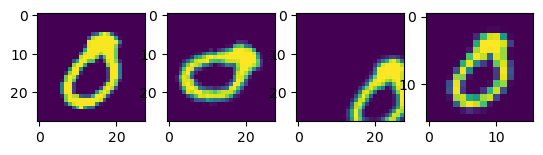

In [67]:
# Define custom rotation function. You may add other parameters to the function.
from skimage.transform import rotate
from skimage.transform import AffineTransform, warp
from skimage.transform import rescale
import random

def random_rotate(image,  angle_range=(-45, 45)):
    angle = np.random.uniform(*angle_range)
    return rotate(image, angle, mode='edge')


def random_translate(image, max_shift=10):
    # Define the maximum translation amount in both x and y directions
    tx = np.random.uniform(-max_shift, max_shift)
    ty = np.random.uniform(-max_shift, max_shift)

    # Define the affine transformation matrix for the translation
    tform = AffineTransform(translation=(tx, ty))

    # Apply the translation to the image using the warp function
    translated_image = warp(image, tform.inverse)

    return translated_image
    
def random_scale(image, scale_range=(0.5, 1.5)):
    # Randomly select a scaling factor within the given range
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    
    # Apply the rescale transformation to the image
    scaled_image = rescale(image, scale_factor, anti_aliasing=True)
    #scaled_image = rescale(image, scale_factor, anti_aliasing=True, mode='reflect')
    
    return scaled_image

fig, axes=plt.subplots(1,4)
axes[0].imshow(zero)
axes[1].imshow(random_rotate(zero))
axes[2].imshow(random_translate(zero))
axes[3].imshow(random_scale(zero))

In [68]:
# We will define 4 sets of new images below

# TODO: Apply only rotation for each "0" and "1" and store results below
rotated_images_zeros = []
rotated_images_ones = []

# TODO: Apply only translation for each "0" and "1" and store results below
translated_images_zeros = []
translated_images_ones = []

# TODO: Apply only scaling for each "0" and "1" and store results below
scaled_images_zeros = []
scaled_images_ones = []

# TODO: Apply all 3 transformations sequentially, in your custom order, for each "0" and "1" and store results below
transformed_images_zeros = []
transformed_images_ones = []

for z in zeros:
    rotated_images_zeros.append(random_rotate(z))
    translated_images_zeros.append(random_translate(z))
    scaled_images_zeros.append(random_scale(z))
    transformed_images_zeros.append(random_rotate(random_translate(random_scale(z))))

for o in ones:
    rotated_images_ones.append(random_rotate(o))
    translated_images_ones.append(random_translate(o))
    scaled_images_ones.append(random_scale(o))
    transformed_images_ones.append(random_rotate(random_translate(random_scale(o))))

In [69]:
# For each of the 4 sets of "0"s and "1"s above, you should find the invaiant features
# and make a plot (similar to section 1.4) - 4 plots in total!
# Use a proper labeling/legend for the plots!


# features for all "0"s
zeros_f1, zeros_f2 = [], []
ones_f1, ones_f2 = [], []
for z in rotated_images_zeros:
    zero_f1, zero_f2 = get_invariant_features(z, inv_to_rotation=True)
    zeros_f1.append(zero_f1)
    zeros_f2.append(zero_f2)
# Fist feature for all "1"s
for o in ones:
    one_f1, one_f2 = get_invariant_features(o, inv_to_rotation=True)
    ones_f1.append(one_f1)
    ones_f2.append(one_f2)
# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(zeros_f1, zeros_f2, color='r', label='zeros')
ax.scatter(ones_f1, ones_f2, color='b', label='ones')
ax.legend(loc='best')
plt.title("Features based on 2 Fourier descriptors")
plt.show()

error: OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


#### Discussion

TODO

## PART 2 - region based descriptors (10 pts)

In this part, you will use the "2"s and "3"s images.

**Objectives overview**:

**1)** *Cluster on compacity*: Based on custom definitions of perimeter and area for each image of "2" and "3" (preprocessed - by you), make a 2D plot with 2-dimensional feature vectors, similar to section 1.4. After that, define the compacity feature for each "2"s and "3"s image. Are you still able to obtain a 1D plot with values clustered in 2 well-defined regions? Discuss your findings. (**6 pts**).

**2)** *Additional method*: Choose one more region-based method (from the course or your own sources - internet allowed) and redo the 1D plot in section 2.1 (or 2D plot, depending on your choosing). Explain your method and your findings. (**4 pts**)

### 2.3. Cluster on compacity (6 pts)

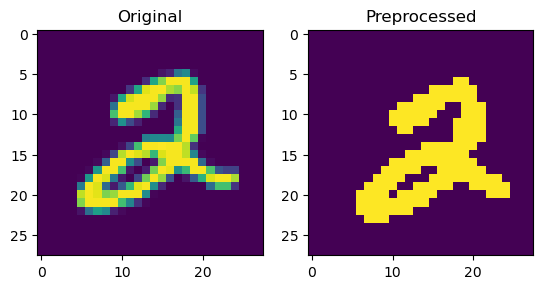

In [70]:
# Preprocess 2s and 3s

kernel_dilate = np.ones((2,2), np.uint8)
kernel_erode = np.ones((2,2), np.uint8)
twos_im_bin = []
threes_im_bin = []
for i in range(len(twos_im)):
    _, im0 = cv2.threshold(twos_im[i], 50, 255, cv2.THRESH_BINARY)
    _, im1 = cv2.threshold(threes_im[i], 50, 255, cv2.THRESH_BINARY)
    
    im0 = cv2.erode(im0,kernel_erode)
    im1 = cv2.erode(im1,kernel_erode)
    im0 = cv2.dilate(im0,kernel_dilate)
    im1 = cv2.dilate(im1,kernel_dilate)
    
    twos_im_bin.append(im0)
    threes_im_bin.append(im1)

fig, axs = plt.subplots(1,2)
axs[0].imshow(twos_im[0])
axs[1].imshow(twos_im_bin[0])
axs[0].set_title('Original')
axs[1].set_title('Preprocessed')
plt.show()

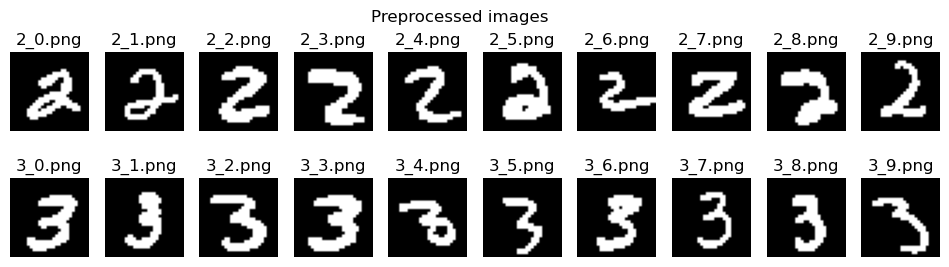

In [71]:
## TODO: Fill the lists below with your preprocessed images of "0"s and "1"s  
twos = twos_im_bin
threes = threes_im_bin

# Plot images
fig, axes = plt.subplots(2, len(zeros), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle("Preprocessed images")
plt.show()

A améliorer en changeant les thresholds pour le pre-processing

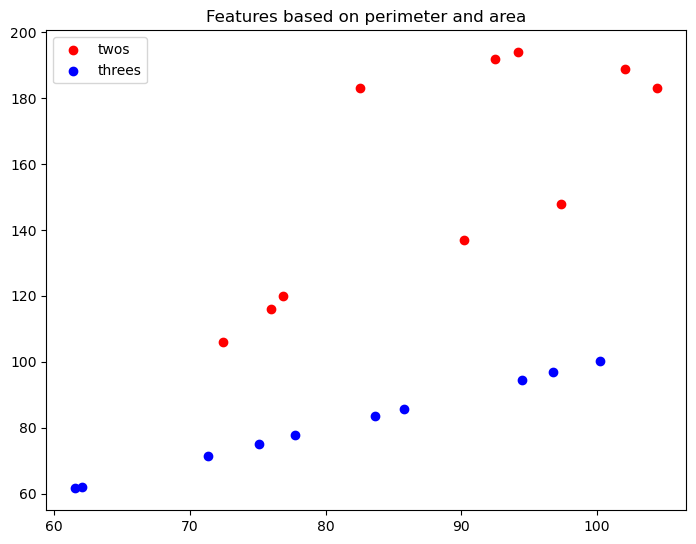

In [72]:
# TODO: Fill the arrays below with the perimeter and area as features for "2"s and "3"s images
twos_f1 = []
twos_f2 = []
threes_f1 = []
threes_f2 = []

from skimage import measure

def compute_features(binary_image):
    """Calculate the perimeter and area of a binary image using measure module from skimage"""
    labeled_image = measure.label(binary_image, connectivity=1)
    props = measure.regionprops(labeled_image)
    region_props = props[0]
    
    perimeter = region_props.perimeter
    area = region_props.area
    
    return perimeter, area

for two, three in zip(twos, threes):
    two_f1, two_f2 = compute_features(two) 
    three_f1, three_f2 = compute_features(three) 
    
    twos_f1.append(two_f1)
    twos_f2.append(two_f2)
    threes_f1.append(three_f1)
    threes_f2.append(three_f1)


# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(twos_f1, twos_f2, color='r', label='twos')
ax.scatter(threes_f1, threes_f2, color='b', label='threes')
ax.legend(loc='best')
plt.title("Features based on perimeter and area")
plt.show()

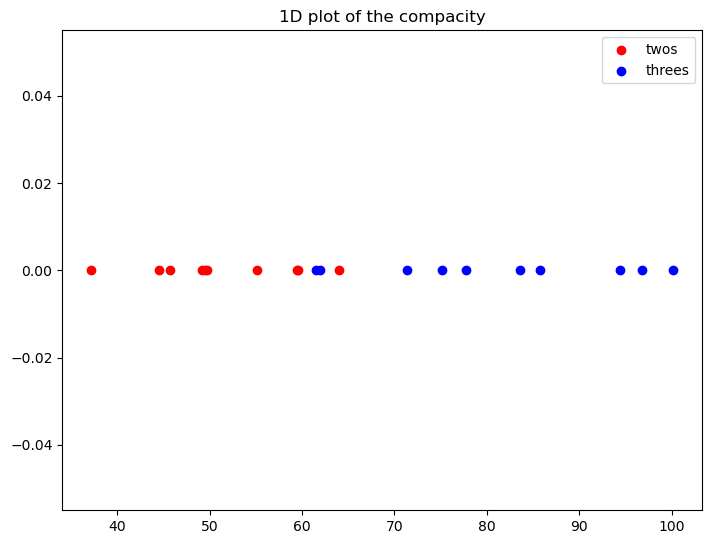

In [73]:
compacity = lambda p,a: p*p/a
twos_compacity = [compacity(p,a) for p,a in zip(twos_f1, twos_f2)]
threes_compacity = [compacity(p,a) for p,a in zip(threes_f1, threes_f2)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(twos_compacity, np.zeros_like(twos_compacity), color='r', label='twos')
ax.scatter(threes_compacity, np.zeros_like(threes_compacity), color='b', label='threes')
ax.legend(loc='best')
plt.title("1D plot of the compacity")
plt.show()

####  Discussion

TODO

### 2.2. Additional method (4 pts)

In [ ]:
# TODO

#### Discussion

TODO